# Report 2 - Film Patron Analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

# Data Cleaning

In [3]:
#First look into the structure of the dataset
films = pd.read_csv("./films.csv")
films.head()

,Movie,Gender,Marital Status,Sinage,Parking,Clean,Overall,Age,Income,Hear About
0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,3.0,1.0,5
1,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,2.0,1.0,5
2,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,4.0,1.0,5
3,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,4.0,1.0,5
4,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,1


Movie: The Name of the Movie the patron watched

Gender: The patron’s gender 1 = male; 2 = female

Marital Status: The patron’s marital status

Sinage: The effectiveness of the signage direction 1 = Excellent; 2 = Good; 3 = Average/Fair; 4 = Poor; 5 = Very Poor

Parking: Rating of the venue’s parking 1 = Excellent; 2 = Good; 3 = Average/Fair; 4 = Poor; 5 = Very Poor

Clean: Rating of the cleanliness of the venue 1 = Excellent; 2 = Good; 3 = Average/Fair; 4 = Poor; 5 = Very Poor

Overall: “Overall customer service experience 1 = Excellent; 2 = Good; 3 = Average/Fair; 4 = Poor; 5 = Very Poor

Age: The patron’s age in years: 1= 1-12; 2 = 13-30; 3 = 31-60; 4 = 60+

Income: The patron’s annual household income: 1 = Less than 50,000 usd; 2 = 50,000 - 100,000 usd; 3 = 100,000 usd+

Hear about: How did the patron hear about Film on the Rocks 1 = television; 2 = newspaper; 3 = radio; 4 = website; 5 = word of mouth

In [4]:
films.columns = ['movie', 'gender', 'marital_status', 'sinage', 'parking', 'clean', 'overall', 'age', 'income', 'hear_about']
films.head()

,movie,gender,marital_status,sinage,parking,clean,overall,age,income,hear_about
0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,3.0,1.0,5
1,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,2.0,1.0,5
2,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,4.0,1.0,5
3,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,4.0,1.0,5
4,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,1


In [5]:
#Find out data types in each column
films.dtypes

movie              object
gender             object
marital_status     object
sinage            float64
parking           float64
clean             float64
overall           float64
age               float64
income            float64
hear_about         object
dtype: object

In [37]:
#Convert all the gender data into strings
films.gender[films.gender == '1'] = 'Male'
films.gender[films.gender == '2'] = 'Female'
films.head() 

,movie,gender,marital_status,sinage,parking,clean,overall,age,income,hear_about
0,Ferris Buellers Day Off,Female,Married,2.0,2.0,2.0,2.0,3.0,1.0,5
1,Ferris Buellers Day Off,Female,Single,1.0,1.0,1.0,1.0,2.0,1.0,5
2,Ferris Buellers Day Off,Male,Married,2.0,4.0,3.0,2.0,4.0,1.0,5
3,Ferris Buellers Day Off,Female,Married,1.0,3.0,2.0,2.0,4.0,1.0,5
4,Ferris Buellers Day Off,Female,Married,1.0,1.0,1.0,1.0,3.0,3.0,1


Text(0.5, 1.0, 'Percent Missing by Variable')

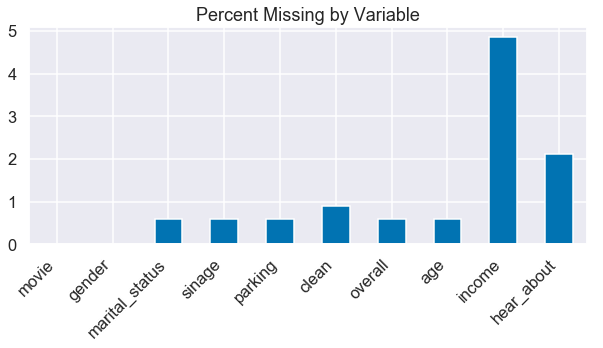

In [64]:
#Find out what percent of each variable is missing
f, ax = plt.subplots(figsize=(10,4))
((films.isnull().sum()/len(films)) * 100).plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Percent Missing by Variable')

Not a significant amount of data is missing, so I decided to keep the original dataset without moving out some variables.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

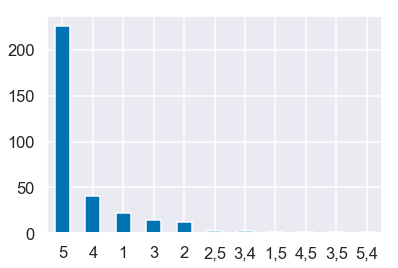

In [7]:
films.hear_about.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

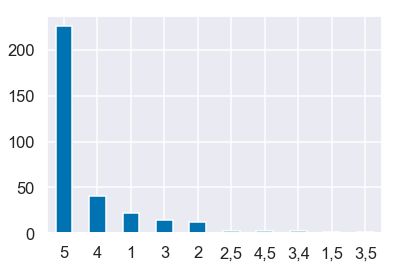

In [8]:
#Since 5,4 and 4,5 mean the same source of 'hear about' but just in different order when the data was entered, so I clean the data here#
films.hear_about[films.hear_about == '5,4'] = '4,5'
films.hear_about.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

1 = television; 2 = newspaper; 3 = radio; 4 = website; 5 = word of mouth; 
(Note: 3,4 = radio & website, same case for 2,5;4,5;3,5;1,5)

Most of the people hear about the film theatre through word of mouth.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

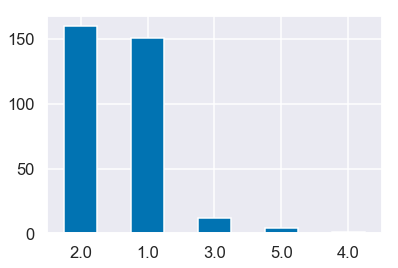

In [9]:
films.overall.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

# Data Description

In [10]:
films.overall.describe()

count    328.000000
mean       1.618902
std        0.689286
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: overall, dtype: float64

In [58]:
films.clean.describe()

count    327.000000
mean       1.681957
std        0.728313
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: clean, dtype: float64

In [59]:
films.parking.describe()

count    328.000000
mean       1.756098
std        0.798484
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: parking, dtype: float64

In [60]:
films.sinage.describe()

count    328.000000
mean       1.884146
std        0.830603
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: sinage, dtype: float64

From the above 4 descriptions, I realize that patrons have high rating for all attibutes of the theatre, as 1 is the highest rating and all the means are between 2 and 1. 

In [61]:
films.age.describe()

count    328.000000
mean       2.338415
std        0.666902
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: age, dtype: float64

The mean of the age falls in (2,3) and 50% of the data falls within 2, and 2 means age 13-30. Hence my conclusion is during the summer, the majority of the patrons are young people (adolescents & adults).

In [62]:
films.income.describe()

count    314.000000
mean       1.834395
std        0.844808
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: income, dtype: float64

The mean of the age falls in (1,2) and 50% of the data falls within 2, and 2 means under 100,000 USD. Hence my conclusion is during the summer, the majority of the patrons are low to medium people.

(array([0, 1]), <a list of 2 Text xticklabel objects>)

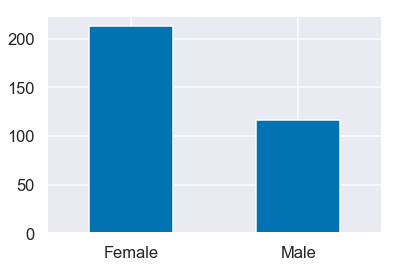

In [14]:
films.gender.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

The customers' gender ratio is female : male = 2:1, which means the major patrons are female.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

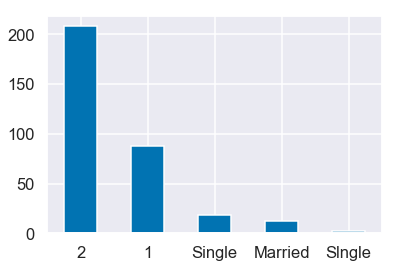

In [15]:
films.marital_status.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

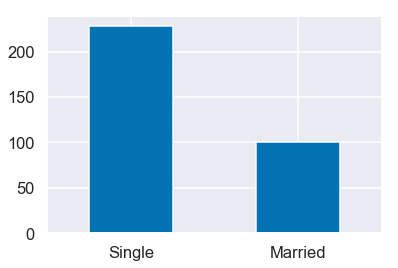

In [23]:
#I found out the data was not clean for this column so I first did the cleaning
films.marital_status[films.marital_status == '1'] = 'Married'
films.marital_status[films.marital_status == '2'] = 'Single'
films.marital_status[films.marital_status == 'Slngle'] = 'Single'

#Redo analysis after cleaning up#
films.marital_status.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

Single people come to the theatre more than married people. Marketing should target more at single people segment.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

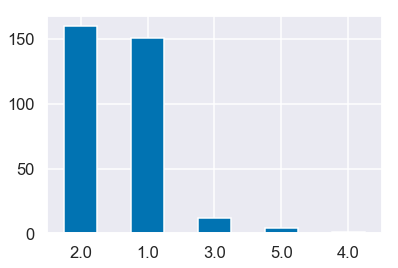

In [65]:
# a glimpse of overall rating of the theatre

films.overall.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

People are generally satisfied with the overall service of the theatre.

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

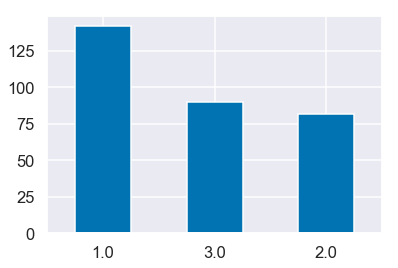

In [66]:
# a glimpse of income of the theatre 

films.income.value_counts().plot(kind='bar')
plt.xticks(rotation=0, horizontalalignment='center')

Income level is not very high among the customers, which means the theatre may target at low-end market.

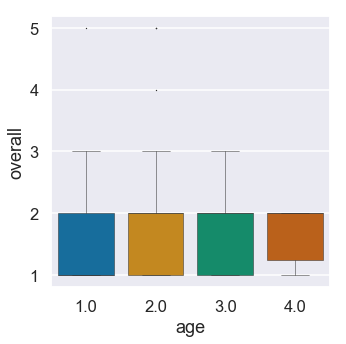

In [36]:
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x="age", y="overall", data=films, fliersize=0.5, linewidth=0.5, ax=ax)

In general, patrons' rating for the theatre is high, no matter how old they are. Old people (60 years +) may be less satisfied with the service, although not significantly, but maybe the theatre should pay more attention to special service provided for the elderly.

# Heatmaps

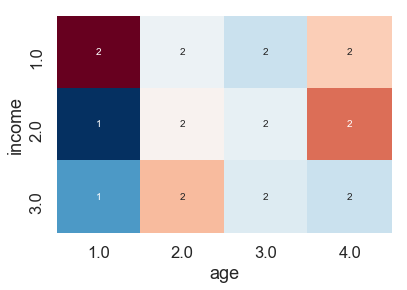

In [50]:
sns.heatmap(films.groupby(['income', 'age'])['overall'].mean().unstack(),
            annot=True, cbar=False, fmt='.0f', cmap='RdBu_r')

I currently cannot figure this heatmap out even after talking to some of my classmates. I will listen to the instructor's suggestion and revise the markdowns here.

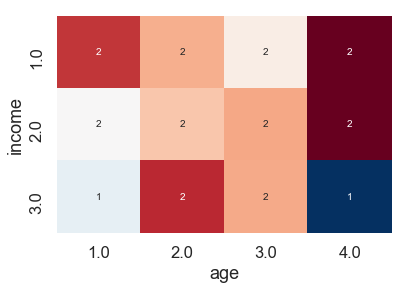

In [51]:
sns.heatmap(films.groupby(['income', 'age'])['clean'].mean().unstack(),
            annot=True, cbar=False, fmt='.0f', cmap='RdBu_r')

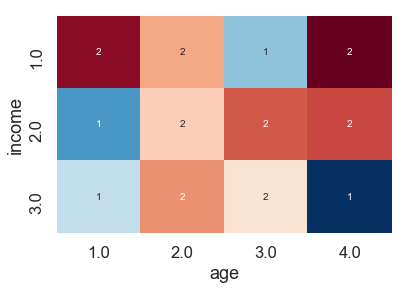

In [52]:
sns.heatmap(films.groupby(['income', 'age'])['parking'].mean().unstack(),
            annot=True, cbar=False, fmt='.0f', cmap='RdBu_r')

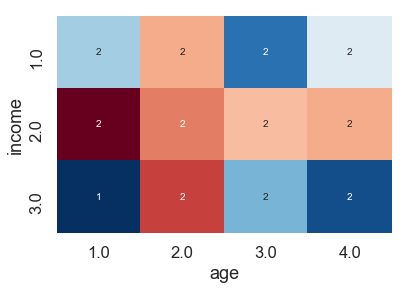

In [56]:
sns.heatmap(films.groupby(['income', 'age'])['sinage'].mean().unstack(),
            annot=True, cbar=False, fmt='.0f', cmap='RdBu_r')